In [1]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from tqdm import tqdm

In [2]:
# Preprocessing
transform = transforms.Compose(
    [
        transforms.Resize(64),
        transforms.CenterCrop(64),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5),inplace=True)
    ]
)

In [3]:
Train_Data_Path= r'C:\Users\pawan\Downloads\Intel\intel\seg_train\seg_train'
Test_Data_Path= r'C:\Users\pawan\Downloads\Intel\intel\seg_test\seg_test'

In [4]:
# Prepareing Dataloaders
train_dataset = ImageFolder(Train_Data_Path, transform=transform)
test_dataset = ImageFolder(Test_Data_Path, transform=transform)

train_loader= DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader= DataLoader(test_dataset, batch_size=32, shuffle=False)

In [5]:
print(train_dataset.class_to_idx)

{'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}


In [6]:
# Building the Neural Architecture

class NaturalSceneCNN(nn.Module):
    def __init__(self):
        super(NaturalSceneCNN, self).__init__()

        # layer 1 ,2 ,3
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 =nn.ReLU()
        self.pool1 =nn.MaxPool2d(kernel_size=2)

        # layer 4, 5, 6
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.relu2 =nn.ReLU()
        self.pool2 =nn.MaxPool2d(kernel_size=2)

        # layer 7, 8, 9,  10
        self.fc1 =nn.Linear(in_features=128*16*16, out_features=128)
        self.relu3 =nn.ReLU()

        self.dropout = nn.Dropout(0.25)
        self.fc2 = nn.Linear(in_features=128, out_features=6)


    def forward(self, x):
        x= self.pool1(self.relu1(self.bn1(self.conv1(x))))
        x= self.pool2(self.relu2(self.bn2(self.conv2(x))))
        x= x.view(x.size(0), -1)
        x= self.relu3(self.fc1(x))
        x= self.dropout(x)
        x= self.fc2(x)
        return x

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = NaturalSceneCNN().to(device)

In [8]:
# Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [9]:
# Training and testing the Model
def train_model(model, train_loader, test_loader, criterion, optimizer):

    num_epochs = 10

    for epoch in range(1, num_epochs+1):
        print(f'\nEpoch: {epoch}/{num_epochs}')
        train_loss, test_loss = [], []
        train_acc, test_acc = [], []


        # Training
        model.train()
        for image, label in tqdm(train_loader , desc= 'Training'):
            image, label = image.to(device), label.to(device)

            # Forward propagation
            optimizer.zero_grad()
            output = model.forward(image)

            # Calculate loss
            loss = criterion(output, label)
            loss.backward()
            optimizer.step()

            # Record metrics
            train_loss.append(loss.item())
            predictions = torch.argmax(output, axis=1)
            accuracy = (predictions == label).float().mean().item()
            train_acc.append(accuracy)


        # Testing
        model.eval()
        for image, label in tqdm(test_loader, desc='Testing'):
            with torch.no_grad():
                image, label = image.to(device), label.to(device)

                output = model.forward(image)
                loss = criterion(output, label)
                test_loss.append(loss.item())

                predictions = torch.argmax(output, axis=1)
                accuracy = (predictions == label).float().mean().item()
                test_acc.append(accuracy)

        # Print metrices
        print(f'\nTraining Loss: {np.mean(train_loss):.4f} ')
        print(f'\nTesting Loss: {np.mean(test_loss):.4f} ')
        print(f'\nTraining Accuracy: {np.mean(train_acc):.4f} ')
        print(f'\nTesting Accuracy: {np.mean(test_acc):.4f} ')

    return model


In [10]:
model = train_model(model, train_loader, test_loader, criterion, optimizer)


Epoch: 1/10


Testing: 100%|██████████| 47/47 [00:26<00:00,  1.80it/s]



Training Loss: 1.9296 

Testing Loss: 1.1260 

Training Accuracy: 0.4109 

Testing Accuracy: 0.5710 

Epoch: 2/10


Testing: 100%|██████████| 47/47 [00:01<00:00, 23.96it/s]



Training Loss: 1.2029 

Testing Loss: 1.0105 

Training Accuracy: 0.5407 

Testing Accuracy: 0.6035 

Epoch: 3/10


Testing: 100%|██████████| 47/47 [00:01<00:00, 25.86it/s]



Training Loss: 1.1057 

Testing Loss: 1.0250 

Training Accuracy: 0.5478 

Testing Accuracy: 0.6013 

Epoch: 4/10


Testing: 100%|██████████| 47/47 [00:01<00:00, 25.44it/s]



Training Loss: 1.0263 

Testing Loss: 1.1732 

Training Accuracy: 0.5879 

Testing Accuracy: 0.6184 

Epoch: 5/10


Testing: 100%|██████████| 47/47 [00:01<00:00, 24.98it/s]



Training Loss: 0.9666 

Testing Loss: 0.8825 

Training Accuracy: 0.6085 

Testing Accuracy: 0.6828 

Epoch: 6/10


Testing: 100%|██████████| 47/47 [00:01<00:00, 24.58it/s]



Training Loss: 0.8809 

Testing Loss: 0.8851 

Training Accuracy: 0.6366 

Testing Accuracy: 0.6836 

Epoch: 7/10


Testing: 100%|██████████| 47/47 [00:01<00:00, 25.70it/s]



Training Loss: 0.8429 

Testing Loss: 0.8336 

Training Accuracy: 0.6513 

Testing Accuracy: 0.7095 

Epoch: 8/10


Testing: 100%|██████████| 47/47 [00:01<00:00, 25.87it/s]



Training Loss: 0.7856 

Testing Loss: 0.8348 

Training Accuracy: 0.6697 

Testing Accuracy: 0.6853 

Epoch: 9/10


Testing: 100%|██████████| 47/47 [00:01<00:00, 24.30it/s]



Training Loss: 0.7448 

Testing Loss: 0.7982 

Training Accuracy: 0.6926 

Testing Accuracy: 0.7084 

Epoch: 10/10


Testing: 100%|██████████| 47/47 [00:02<00:00, 22.47it/s]


Training Loss: 0.7241 

Testing Loss: 0.8126 

Training Accuracy: 0.7019 

Testing Accuracy: 0.7034 


In [11]:
# Defining categories to filter the images
class_names = [ 'buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
folder_path = r'C:\Users\pawan\Downloads\Intel\intel\seg_pred\seg_pred'

def predict_folder(model, folder_path, device):
    model.eval()
    model.to(device)

    predictions ={}

    image_files = [f for f in os.listdir(folder_path) if f.endswith('.jpg')]

    print(f'Predicting {len(image_files)} images from {folder_path}')

    with torch.no_grad():
        for file_name in image_files:
            # Loading and processing image
            image_path = os.path.join(folder_path, file_name)
            image = Image.open(image_path).convert('RGB')

            # Applying same transformation
            img_tensor = transform(image).unsqueeze(0).to(device)

            # Forward propagation
            output = model(img_tensor)
            _, predicted_idx = torch.max(output,1)

            # Get predicted class name
            label = class_names[predicted_idx.item()]
            predictions[file_name]= label

    return predictions


In [12]:
# Execution
pred_results= predict_folder(model,folder_path,device)

Predicting 500 images from C:\Users\pawan\Downloads\Intel\intel\seg_pred\seg_pred


In [13]:
# Print first 10 result
print('\nSample Predictions:')
for i, (fname , label) in enumerate(list(pred_results.items())[:10]):
    print(f'{i+1}. {fname}: {label}')


Sample Predictions:
1. 10340.jpg: buildings
2. 10342.jpg: sea
3. 10352.jpg: street
4. 10356.jpg: buildings
5. 10360.jpg: forest
6. 10363.jpg: glacier
7. 10371.jpg: street
8. 10375.jpg: street
9. 10377.jpg: sea
10. 10381.jpg: buildings


In [14]:
def show_prediction(image_path, label):
    img = Image.open(image_path)
    plt.imshow(img)
    plt.title(f"Predicted: {label}")
    plt.axis('off')
    plt.show()

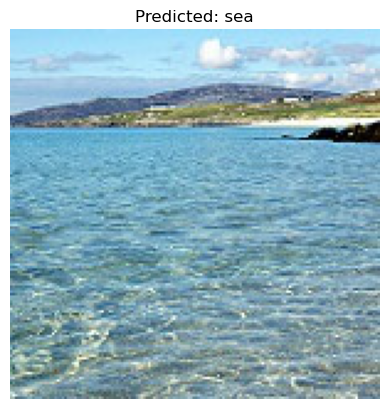

In [15]:
# Example: Show any predicted file
predicted_file = list(pred_results.keys())[1]
show_prediction(os.path.join(folder_path, predicted_file), pred_results[predicted_file])